In [1]:
import os
import tqdm
import json
import nemo
import shutil
import string
import fnmatch
import pathlib
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nemo.collections import asr as nemo_asr

In [2]:
BASE = pathlib.Path('/home/stanislavv/data/libritts')
LOCAL_DATA_ROOT = BASE / 'LibriTTS'
NGC_DATA_ROOT = BASE / 'LibriTTS_ngc'
LOCAL_MANIFEST_ROOT = BASE / 'local'
NGC_MANIFEST_ROOT = BASE / 'ngc'

In [50]:
def process(part):
    def read_text(file):
        with open(file, 'r') as f:
            return str(f.read())
    
    def write_manifest(data, file):
        with open(file, 'w') as f:
            for example in data:
                f.write(json.dumps(example) + '\n')
    
    ngc_datat_root = NGC_DATA_ROOT / part
    ngc_datat_root.mkdir(parents=True, exist_ok=True)
    
    wavs = list((LOCAL_DATA_ROOT / part).glob('*/*/*.wav'))
    local_data, ngc_data = [], []
    for wav in tqdm.tqdm(wavs):
        shutil.copy(wav, ngc_datat_root / wav.name)
        
        normalized_text = read_text(wav.with_suffix('.normalized.txt'))
        original_text = read_text(wav.with_suffix('.original.txt'))
        duration = float(subprocess.check_output(f'soxi -D {wav}', shell=True))
        speaker = int(wav.name.split('_')[0])

        local_data.append(
            dict(
                audio_filepath=str(wav),
                duration=duration,
                normalized_text=normalized_text,
                original_text=original_text,
                speaker=speaker,
            )
        )
        
        ngc_data.append(
            dict(
                audio_filepath=str(pathlib.Path('/data/libritts') / part / wav.name),
                duration=duration,
                normalized_text=normalized_text,
                original_text=original_text,
                speaker=speaker,
            )
        )

    LOCAL_MANIFEST_ROOT.mkdir(parents=True, exist_ok=True)
    write_manifest(local_data, LOCAL_MANIFEST_ROOT / f'{part}.json')

    NGC_MANIFEST_ROOT.mkdir(parents=True, exist_ok=True)
    write_manifest(ngc_data, NGC_MANIFEST_ROOT / f'{part}.json')


process('dev-clean')

100%|██████████| 5736/5736 [00:44<00:00, 128.77it/s]


In [51]:
for part in ['dev-other', 'test-clean', 'test-other', 'train-clean-100', 'train-clean-360', 'train-other-500']:
    print(part)
    process(part)

  0%|          | 13/4613 [00:00<00:35, 127.91it/s]

dev-other


  0%|          | 14/4837 [00:00<00:36, 132.77it/s]

test-clean


  0%|          | 14/5120 [00:00<00:37, 135.68it/s]

test-other


100%|██████████| 5120/5120 [00:38<00:00, 131.62it/s]


train-clean-100


100%|██████████| 33236/33236 [04:31<00:00, 122.43it/s]


train-clean-360


100%|██████████| 116500/116500 [19:11<00:00, 101.19it/s]


train-other-500


100%|██████████| 205044/205044 [39:53<00:00, 85.67it/s]


In [53]:
shutil.copy(LOCAL_DATA_ROOT / 'eval_sentences10.tsv', LOCAL_MANIFEST_ROOT / 'eval_sentences10.tsv')
shutil.copy(LOCAL_DATA_ROOT / 'speakers.tsv', LOCAL_MANIFEST_ROOT / 'speakers.tsv')
shutil.copy(LOCAL_DATA_ROOT / 'eval_sentences10.tsv', NGC_MANIFEST_ROOT / 'eval_sentences10.tsv')
shutil.copy(LOCAL_DATA_ROOT / 'speakers.tsv', NGC_MANIFEST_ROOT / 'speakers.tsv')

PosixPath('/home/stanislavv/data/libritts/ngc/speakers.tsv')

In [54]:
# !cat train-clean-100.json train-clean-360.json train-other-500.json >train-all.json

## Analysis

In [7]:
alphabet = set()
for part in [
    'dev-clean',
    'dev-other',
    'test-clean',
    'test-other',
    'train-all',
]:
    print(part)
    manifest = LOCAL_MANIFEST_ROOT / f'{part}.json'
    with open(manifest, 'r') as f:
        for line in f:
            text = json.loads(line)['normalized_text']
            alphabet.update(text)

dev-clean
dev-other
test-clean
test-other
train-all


In [25]:
alpha = string.ascii_letters
non_ascii = alphabet - set(alpha)
print(*non_ascii)

æ ( ê ô . ! { ] ' ) } [ ; — ò é : œ ¯ "   ñ , ? - è /


In [24]:
punct = '()[]{}!?,.;:-/\'" '
left = non_ascii - set(punct)
print(*left)

æ — ò ê ô é œ è ¯ ñ


In [26]:
print(*alpha)
print(*punct)
print(*left)

a b c d e f g h i j k l m n o p q r s t u v w x y z A B C D E F G H I J K L M N O P Q R S T U V W X Y Z
( ) [ ] { } ! ? , . ; : - / ' "  
æ — ò ê ô é œ è ¯ ñ


In [4]:
TRAIN_DATA = '/home/stanislavv/data/libritts/local/train-all.json'
train_all_sp = set(e['speaker'] for e in nemo.collections.asr.parts.manifest.item_iter(TRAIN_DATA))
len(train_all_sp)

2311

In [32]:
DATA = '/home/stanislavv/data/libritts/local/dev-clean.json'
dev_clean_sp = set(e['speaker'] for e in nemo.collections.asr.parts.manifest.item_iter(DATA))
len(dev_clean_sp)

40

In [34]:
DATA = '/home/stanislavv/data/libritts/local/dev-other.json'
dev_other_sp = set(e['speaker'] for e in nemo.collections.asr.parts.manifest.item_iter(DATA))
len(dev_other_sp)

33

In [6]:
train_all_sp & dev_clean_sp

set()

In [8]:
dev_clean_sp & dev_other_sp

set()

In [9]:
train_all_sp & dev_other_sp

set()

In [12]:
for item in items:
    if item['speaker'] == 6358:
        print(item)

{'audio_file': '/home/stanislavv/data/libritts/LibriTTS/train-other-500/6358/73329/6358_73329_000053_000006.wav', 'duration': 3.62, 'text': 'A doorway cut near the fireplace showed there was probably an inner chamber.', 'offset': None, 'speaker': 6358, 'id': 188015}
{'audio_file': '/home/stanislavv/data/libritts/LibriTTS/train-other-500/6358/73329/6358_73329_000051_000002.wav', 'duration': 10.07, 'text': 'Accustomed to the life of a convent, they could not conceive of any other; and when one morning their bars and gratings were flung down, they had shuddered at finding themselves free.', 'offset': None, 'speaker': 6358, 'id': 188016}
{'audio_file': '/home/stanislavv/data/libritts/LibriTTS/train-other-500/6358/73329/6358_73329_000079_000001.wav', 'duration': 17.09, 'text': "Beneath the dome of saint Peter's in Rome, God had never seemed more majestic to man than he did now in this refuge of poverty and to the eyes of these Christians,--so true is it that between man and God all mediatio

In [11]:
speakers = list(sorted(set([item['speaker'] for item in items])))
6358 in speakers

True

In [15]:
SPEAKER_TSV = '/home/stanislavv/data/libritts/local/speakers.tsv'
tsv_speakers = list(pd.read_csv(SPEAKER_TSV, sep='\t')['READER'])
tsv_speakers[:10]

['F', 'F', 'M', 'F', 'F', 'F', 'F', 'M', 'M', 'M']

In [18]:
pd.read_csv(SPEAKER_TSV, sep='\t').index

Int64Index([  14,   16,   17,   19,   20,   22,   23,   25,   26,   27,
            ...
            8867, 8875, 8879, 8887, 8897, 8975, 9000, 9022, 9023, 9026],
           dtype='int64', length=2484)

# Embeddings

In [2]:
EMB_ROOT = '/home/stanislavv/data/libritts/speaker-embeddings-22k'
SPEAKERS_TABLE = '/home/stanislavv/data/libritts/ngc/speakers.tsv'
EMB_SIZE = 256

In [3]:
sid_to_i = {sid: i for i, sid in enumerate(pd.read_csv(SPEAKERS_TABLE, sep='\t').index)}
len(sid_to_i)

2484

In [4]:
embs = np.zeros((len(sid_to_i), EMB_SIZE))
nums = np.zeros(len(sid_to_i))

In [19]:
list(path.glob('*/*/*/*.npy'))[70:100]

[PosixPath('/home/stanislavv/data/libritts/speaker-embeddings-22k/train-other-500/705/157945/705_157945_000026_000000.npy'),
 PosixPath('/home/stanislavv/data/libritts/speaker-embeddings-22k/train-other-500/705/157945/705_157945_000005_000011.npy'),
 PosixPath('/home/stanislavv/data/libritts/speaker-embeddings-22k/train-other-500/705/157945/705_157945_000005_000002.npy'),
 PosixPath('/home/stanislavv/data/libritts/speaker-embeddings-22k/train-other-500/705/157945/705_157945_000008_000003.npy'),
 PosixPath('/home/stanislavv/data/libritts/speaker-embeddings-22k/train-other-500/705/157945/705_157945_000024_000002.npy'),
 PosixPath('/home/stanislavv/data/libritts/speaker-embeddings-22k/train-other-500/705/157945/705_157945_000011_000001.npy'),
 PosixPath('/home/stanislavv/data/libritts/speaker-embeddings-22k/train-other-500/705/157945/705_157945_000020_000000.npy'),
 PosixPath('/home/stanislavv/data/libritts/speaker-embeddings-22k/train-other-500/705/157945/705_157945_000008_000002.npy'),


In [9]:
n1, n2

(PosixPath('/home/stanislavv/data/libritts/speaker-embeddings-22k/train-other-500/705/167610/705_167610_000013_000001.npy'),
 PosixPath('/home/stanislavv/data/libritts/speaker-embeddings-22k/train-other-500/705/167610/705_167610_000007_000008.npy'))

In [12]:
arr1, arr2 = np.load(str(n1)), np.load(str(n2))
arr1, arr2

(array([0.1268699 , 0.00728266, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.03883874, 0.        , 0.02312475,
        0.03784902, 0.13401358, 0.0447265 , 0.05487893, 0.        ,
        0.        , 0.06177042, 0.04770177, 0.0533527 , 0.00207578,
        0.03082609, 0.13977274, 0.        , 0.        , 0.        ,
        0.02725229, 0.        , 0.        , 0.        , 0.        ,
        0.17177697, 0.04846541, 0.15689404, 0.04760951, 0.01593472,
        0.10137249, 0.01318053, 0.02166847, 0.        , 0.        ,
        0.        , 0.        , 0.00050788, 0.10653368, 0.00554112,
        0.        , 0.        , 0.        , 0.07533035, 0.        ,
        0.        , 0.02383987, 0.        , 0.        , 0.        ,
        0.00026234, 0.06351399, 0.        , 0.03671735, 0.        ,
        0.07109461, 0.        , 0.        , 0.        , 0.02505075,
        0.        , 0.        , 0.        , 0.        , 0.00769077,
        0.02832156, 0.13886626, 0.0072269 , 0.00

In [16]:
(arr1 - arr2).mean()

-0.0011840727

In [14]:
arr1[:10]

array([0.1268699 , 0.00728266, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03883874, 0.        , 0.02312475],
      dtype=float32)

In [15]:
arr2[:10]

array([0.1333864 , 0.0263083 , 0.00296715, 0.        , 0.        ,
       0.00165917, 0.        , 0.03102583, 0.        , 0.04338206],
      dtype=float32)

In [5]:
path = pathlib.Path(EMB_ROOT)
files = []
for f in tqdm.tqdm(path.glob('*/*/*/*.npy')):
    speaker_id = int(f.name.split('_')[0])
    arr = np.load(str(f))
    
    embs[sid_to_i[speaker_id]] += arr
    nums[sid_to_i[speaker_id]] += 1

75117it [00:30, 2511.04it/s]

KeyboardInterrupt: 

In [26]:
embs = {}
for f in tqdm.tqdm(path.glob('*/*/*/*.npy')):
    embs[f.stem] = np.load(str(f))


0it [00:00, ?it/s]
395it [00:00, 3944.77it/s]
783it [00:00, 3922.39it/s]
1175it [00:00, 3920.02it/s]
1528it [00:00, 3791.64it/s]
1912it [00:00, 3804.46it/s]
2227it [00:00, 3566.41it/s]
2607it [00:00, 3631.45it/s]
2994it [00:00, 3698.54it/s]
3380it [00:00, 3745.34it/s]
3768it [00:01, 3784.62it/s]
4157it [00:01, 3814.59it/s]
4541it [00:01, 3821.17it/s]
4921it [00:01, 3812.18it/s]
5299it [00:01, 3797.58it/s]
5678it [00:01, 3793.34it/s]
6060it [00:01, 3799.35it/s]
6444it [00:01, 3810.47it/s]
6832it [00:01, 3826.05it/s]
7217it [00:01, 3832.42it/s]
7602it [00:02, 3835.24it/s]
7986it [00:02, 3830.45it/s]
8375it [00:02, 3847.22it/s]
8760it [00:02, 3838.89it/s]
9144it [00:02, 3697.65it/s]
9515it [00:02, 3659.76it/s]
9882it [00:02, 3656.16it/s]
10269it [00:02, 3716.20it/s]
10658it [00:02, 3766.45it/s]
11036it [00:02, 3579.07it/s]
11405it [00:03, 3609.29it/s]
11779it [00:03, 3647.43it/s]
12167it [00:03, 3711.67it/s]
12554it [00:03, 3756.61it/s]
12943it [00:03, 3795.23it/s]
13332it [00:03, 3820.9

91081it [00:26, 2499.05it/s]
91331it [00:26, 2490.55it/s]
91581it [00:26, 2492.62it/s]
91831it [00:26, 2490.68it/s]
92081it [00:26, 2487.94it/s]
92333it [00:26, 2494.96it/s]
92585it [00:26, 2501.69it/s]
92836it [00:27, 2497.82it/s]
93086it [00:27, 2498.27it/s]
93336it [00:27, 2495.57it/s]
93588it [00:27, 2500.38it/s]
93839it [00:27, 2501.59it/s]
94090it [00:27, 2500.11it/s]
94342it [00:27, 2504.09it/s]
94595it [00:27, 2509.04it/s]
94847it [00:27, 2512.16it/s]
95100it [00:28, 2514.90it/s]
95354it [00:28, 2521.58it/s]
95608it [00:28, 2525.73it/s]
95861it [00:28, 2519.08it/s]
96113it [00:28, 2517.07it/s]
96365it [00:28, 2512.86it/s]
96617it [00:28, 2511.68it/s]
96872it [00:28, 2520.57it/s]
97126it [00:28, 2524.12it/s]
97379it [00:28, 2516.39it/s]
97631it [00:29, 2503.45it/s]
97882it [00:29, 2485.08it/s]
98133it [00:29, 2491.25it/s]
98383it [00:29, 2483.26it/s]
98632it [00:29, 2484.90it/s]
98881it [00:29, 2484.48it/s]
99130it [00:29, 2480.26it/s]
99379it [00:29, 2472.75it/s]
99627it [00:29

153951it [00:51, 2476.08it/s]
154205it [00:51, 2492.63it/s]
154456it [00:52, 2496.76it/s]
154710it [00:52, 2509.20it/s]
154962it [00:52, 2512.43it/s]
155214it [00:52, 2509.12it/s]
155465it [00:52, 2507.63it/s]
155720it [00:52, 2517.72it/s]
155972it [00:52, 2497.70it/s]
156225it [00:52, 2506.92it/s]
156476it [00:52, 2507.32it/s]
156727it [00:52, 2491.12it/s]
156981it [00:53, 2503.01it/s]
157234it [00:53, 2509.60it/s]
157488it [00:53, 2516.65it/s]
157742it [00:53, 2521.93it/s]
157995it [00:53, 2514.22it/s]
158248it [00:53, 2514.65it/s]
158500it [00:53, 2509.50it/s]
158753it [00:53, 2513.57it/s]
159007it [00:53, 2518.98it/s]
159259it [00:53, 2519.27it/s]
159514it [00:54, 2526.61it/s]
159767it [00:54, 2524.06it/s]
160020it [00:54, 2515.05it/s]
160272it [00:54, 2513.92it/s]
160525it [00:54, 2518.28it/s]
160777it [00:54, 2518.15it/s]
161029it [00:54, 2391.07it/s]
161283it [00:54, 2433.50it/s]
161536it [00:54, 2461.38it/s]
161788it [00:54, 2478.13it/s]
162041it [00:55, 2490.96it/s]
162295it [

216715it [01:16, 2552.89it/s]
216971it [01:16, 2553.81it/s]
217227it [01:16, 2555.34it/s]
217483it [01:17, 2553.84it/s]
217739it [01:17, 2553.99it/s]
217995it [01:17, 2551.66it/s]
218251it [01:17, 2548.56it/s]
218506it [01:17, 2538.80it/s]
218760it [01:17, 2235.33it/s]
219013it [01:17, 2315.74it/s]
219267it [01:17, 2376.65it/s]
219520it [01:17, 2420.40it/s]
219773it [01:18, 2449.77it/s]
220028it [01:18, 2477.71it/s]
220281it [01:18, 2491.38it/s]
220536it [01:18, 2506.04it/s]
220788it [01:18, 2509.97it/s]
221041it [01:18, 2514.94it/s]
221294it [01:18, 2517.49it/s]
221548it [01:18, 2523.43it/s]
221801it [01:18, 2521.02it/s]
222054it [01:18, 2520.45it/s]
222308it [01:19, 2525.86it/s]
222562it [01:19, 2529.36it/s]
222816it [01:19, 2530.97it/s]
223070it [01:19, 2530.38it/s]
223325it [01:19, 2534.88it/s]
223579it [01:19, 2535.74it/s]
223833it [01:19, 2459.04it/s]
224086it [01:19, 2478.96it/s]
224340it [01:19, 2495.44it/s]
224594it [01:19, 2507.11it/s]
224848it [01:20, 2514.39it/s]
225102it [

279905it [01:41, 2553.03it/s]
280161it [01:41, 2551.41it/s]
280419it [01:42, 2557.17it/s]
280675it [01:42, 2555.50it/s]
280931it [01:42, 2553.91it/s]
281187it [01:42, 2554.01it/s]
281443it [01:42, 2554.50it/s]
281699it [01:42, 2543.12it/s]
281954it [01:42, 2543.84it/s]
282209it [01:42, 2543.35it/s]
282464it [01:42, 2544.39it/s]
282720it [01:42, 2548.16it/s]
282976it [01:43, 2549.21it/s]
283231it [01:43, 2538.77it/s]
283487it [01:43, 2543.18it/s]
283742it [01:43, 2540.22it/s]
283998it [01:43, 2543.31it/s]
284254it [01:43, 2545.97it/s]
284509it [01:43, 2545.23it/s]
284765it [01:43, 2547.11it/s]
285020it [01:43, 2545.69it/s]
285275it [01:43, 2545.70it/s]
285531it [01:44, 2549.59it/s]
285787it [01:44, 2550.18it/s]
286043it [01:44, 2545.18it/s]
286298it [01:44, 2542.86it/s]
286553it [01:44, 2542.51it/s]
286808it [01:44, 2541.69it/s]
287063it [01:44, 2539.80it/s]
287318it [01:44, 2541.60it/s]
287573it [01:44, 2541.08it/s]
287829it [01:44, 2544.04it/s]
288085it [01:45, 2546.14it/s]
288340it [

342236it [02:07, 2526.59it/s]
342489it [02:07, 2404.87it/s]
342745it [02:07, 2449.17it/s]
342998it [02:07, 2470.48it/s]
343246it [02:07, 2468.60it/s]
343495it [02:08, 2474.46it/s]
343748it [02:08, 2488.95it/s]
343999it [02:08, 2493.03it/s]
344249it [02:08, 2493.08it/s]
344501it [02:08, 2498.89it/s]
344754it [02:08, 2506.89it/s]
345005it [02:08, 2507.24it/s]
345256it [02:08, 2484.96it/s]
345508it [02:08, 2493.31it/s]
345761it [02:08, 2503.41it/s]
346014it [02:09, 2508.58it/s]
346265it [02:09, 2500.99it/s]
346516it [02:09, 2493.21it/s]
346767it [02:09, 2497.67it/s]
347017it [02:09, 2490.05it/s]
347270it [02:09, 2500.44it/s]
347521it [02:09, 2501.48it/s]
347772it [02:09, 2480.60it/s]
348027it [02:09, 2499.56it/s]
348282it [02:09, 2514.33it/s]
348535it [02:10, 2516.54it/s]
348787it [02:10, 2512.95it/s]
349039it [02:10, 2495.85it/s]
349291it [02:10, 2501.89it/s]
349542it [02:10, 2402.79it/s]
349791it [02:10, 2427.62it/s]
350043it [02:10, 2452.92it/s]
350298it [02:10, 2480.95it/s]
350547it [

In [27]:
len(embs)

375086

In [49]:
sembs = embs / np.where(nums == 0.0, 1, nums)[:, np.newaxis]
sembs.shape

(2484, 256)

In [50]:
sembs.min(), sembs.max()

(0.0, 0.3968268036842346)

In [51]:
np.save('/home/stanislavv/data/librimeta/speaker-embs/16k.npy', sembs)

In [22]:
e = next(nemo.collections.asr.parts.manifest.item_iter(MAP_PATH))
e

{'audio_file': '/home/stanislavv/data/libritts/LibriTTS/train-clean-100/1594/135914/1594_135914_000014_000001.wav',
 'duration': 4.44,
 'text': 'Fetnah concluded, that he had not been able to survive the pain of losing her.',
 'offset': None,
 'speaker': 1594,
 'id': 0}

In [25]:
pathlib.Path(e['audio_file']).stem

'1594_135914_000014_000001'

In [38]:
NAME = 'test-clean'
MAP_PATH = f'/home/stanislavv/data/libritts/local/{NAME}.json'
map_embs = []
for e in tqdm.tqdm(nemo.collections.asr.parts.manifest.item_iter(MAP_PATH)):
    map_embs.append(embs[pathlib.Path(e['audio_file']).stem])

map_embs = np.stack(map_embs)
map_embs.shape


0it [00:00, ?it/s]
4837it [00:00, 40354.39it/s]


(4837, 256)

In [39]:
np.save(f'/home/stanislavv/data/librimeta/speaker-embs/{NAME}.npy', map_embs)

# Lens

In [3]:
durs = np.load(
    file='/home/stanislavv/data/librimeta/durs/libritts_original-qn15x5_24k/train-all_full-pad.npy',
    allow_pickle=True,
)
durs.shape

(354780, 2)

In [5]:
lens = np.array([b.sum() + d.sum() for b, d in durs])
lens.shape

(354780,)

In [18]:
lens.max()

4388

In [19]:
lens.min()

11

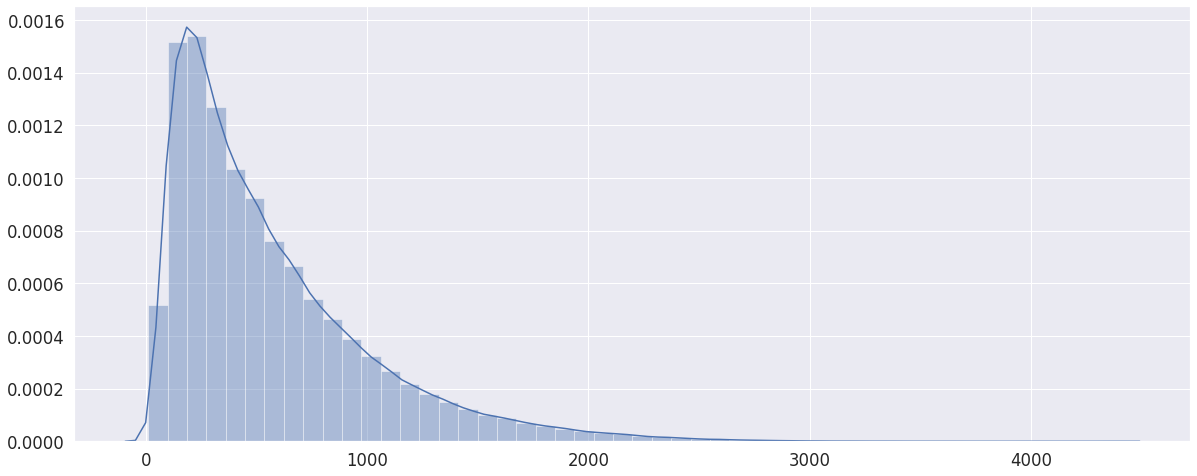

In [25]:
sns.set(font_scale=1.5)
plt.figure(figsize=(20, 8))
sns.distplot(lens);

In [29]:
DATA = '/home/stanislavv/data/libritts/local/train-all.json'
adurs = np.array([e['duration'] for e in nemo.collections.asr.parts.manifest.item_iter(DATA)])
len(adurs)

354780

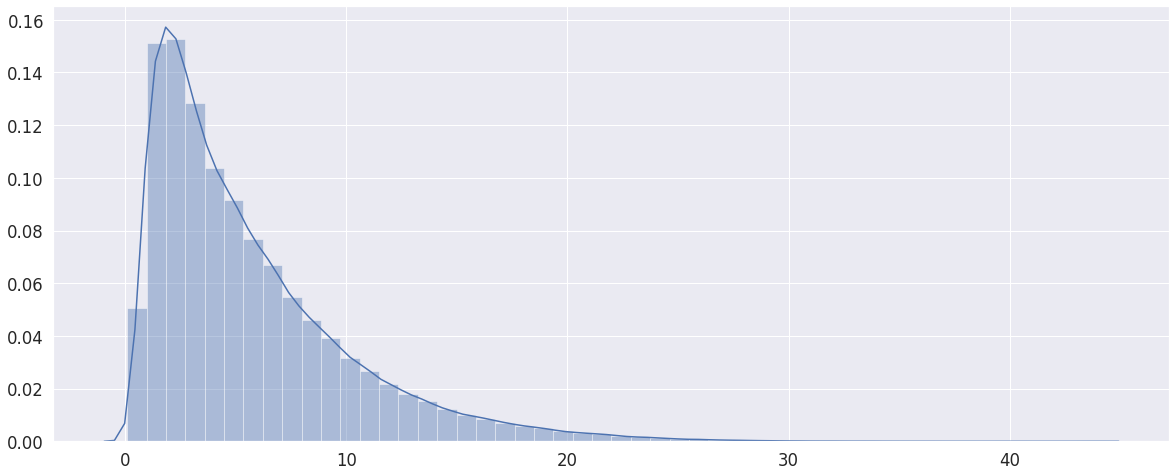

In [30]:
sns.set(font_scale=1.5)
plt.figure(figsize=(20, 8))
sns.distplot(adurs);

In [33]:
adurs.max()

43.88

In [34]:
lens.max()

4388